## Mountain Car
1. A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.
2. State is continuous in two dimensions:
	a. Position from -1.2 to 0.6
	b. Velocity from -0.07 to 0.07
3. Action is discrete:
	a. 0 : Push left
	b. 1 : No push
	c. 2 : Push right
4. Reward is -1 for each time step, until goal position of 0.5 is reached.  There is no penalty for climbing the left hill, which upon reached acts as a wall.
5. Episode starts in a random position from -0.6 to -0.4 with no velocity.
6. The episode ends when you reach 0.5 position, or if 200 iterations are reached.
<img src="images/M7A1-P1.jpg" alt="M4A1-P3" width="500"/>

In [1]:
import gym
import numpy as np
from typing import Callable, List, Tuple, Sequence
from collections import defaultdict
import sys
import plots
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""
from math import floor, log
from itertools import zip_longest

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates



def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


### Semi-gradient SARSA
<img src="images/M7A1-P2.png" alt="M4A1-P3" width="500"/>

In [7]:
class semi_gradient_sarsa_control(object):
    def __init__(self, env : gym.envs, gamma : float = 1, alpha : float = 0.01, epsilon_max : float = 1, n_tiles :int = 8,\
                epsilon_min : float = 0.005, state_action_rep_size :int = 2048, n_tilings : int = 8, n_episode = 10000) -> None:
        self.env = env
        self.gamma = gamma
        self.n_episode = n_episode
        self.epsilon = epsilon_max
        self.decay = (epsilon_max - epsilon_min)/n_episode
        self.alpha = alpha
        self.state_action_rep_size = state_action_rep_size
        self.n_tilings = n_tilings
        self.n_tiles = n_tiles
        self.iht = IHT(state_action_rep_size)
        self.weights = np.zeros(state_action_rep_size)
        
    def get_state_action_representation(self, state : List, action : int) -> List:
        '''
        Return binary vector of size 'state_action_rep_size' as the representation for state-action pair.
        State is a vector of two values. Action is an integer.
        '''
        state_action_rep = np.zeros(self.state_action_rep_size)
        x_scale = self.n_tiles / (self.env.observation_space.high[0] - self.env.observation_space.low[0])
        v_scale = self.n_tiles / (self.env.observation_space.high[1] - self.env.observation_space.low[1])
        t = tiles(self.iht, self.n_tilings, [ x_scale * state[0], v_scale * state[1]], [action])
        state_action_rep[t] = 1
        return state_action_rep
        
    
    def action_value_function(self, state : List, action : int ) -> float:
        '''
        Return the state-action value for the state,action pair.
        State is a vector of two values. Action is an integer
        '''
        return np.dot(self.weights,self.get_state_action_representation(state,action))
    
    def policy(self, state : List) -> object:
        eps = np.random.uniform()
        if(eps < self.epsilon):
            action = np.random.choice(range(self.env.action_space.n))
            state_action_value = self.action_value_function(state,action)
        else:
            action = -1
            state_action_value = float("-inf")
            for a in range(self.env.action_space.n):
                value = self.action_value_function(state,a)
                if(state_action_value < value):
                    action = a
                    state_action_value = value
        return action, state_action_value
    
    def optimize_policy(self) -> None:
        '''
        Use semi-gradient SARSA to find optimal policy. 
        '''
        self.all_rewards = [] 
        solved = False
        solved_in = -1
        for episode_number in range(self.n_episode):
            state = self.env.reset()
            action, action_value = self.policy(state)
            total_reward = 0
            while(True):
                next_state, reward, done, info = self.env.step(action)
                if(done):
                    target = reward
                else:
                    next_action, next_action_value = self.policy(next_state)
                    target = reward + self.gamma * next_action_value
                self.weights = self.weights + self.alpha * (target - action_value) * self.get_state_action_representation(state,action)
                total_reward = total_reward + reward
                if(done):
                    self.all_rewards.append(total_reward)
                    if((episode_number+1) % 100 == 0):
                        print('\rEpisode {}/{} \t| Average reward : {}'.format(episode_number + 1, self.n_episode, np.mean(self.all_rewards[-100:])), end = '')
                        sys.stdout.flush()
                    if(np.mean(self.all_rewards[-100:]) >= -110):
                        solved = True
                        solved_in = episode_number + 1
                    break
                state = next_state
                action = next_action
                action_value = next_action_value
            self.epsilon = self.epsilon - self.decay
            if(solved):
                print('\nSolved in {} episodes!!'.format(solved_in))
                self.play()
                break
        self.plot_rewards()
    
    def play(self) -> None:
        '''
        Visulatize the learned agent.
        '''
        for i in range(10):
            state = self.env.reset()
            while(True):
                self.env.render()
                action, _  = self.policy(state)
                next_state, reward, done, info = self.env.step(action)
                if(done):
                    break
                state = next_state
            self.env.close()
                
    def plot_rewards(self) -> None:
        '''
        Plot the reward.
        '''
        def moving_average(x, w):
            return np.convolve(x, np.ones(w), 'valid') / w
        fig = plt.figure()
        averaged_rolling_rewards = moving_average(self.all_rewards,100)
        plt.plot(range(len(averaged_rolling_rewards)), averaged_rolling_rewards)
        plt.xlabel('Episode')
        plt.ylabel("Avg. rewards")
        plt.show()
                    
            

Episode 1300/10000 	| Average reward : -114.43
Solved in 1362 episodes!!


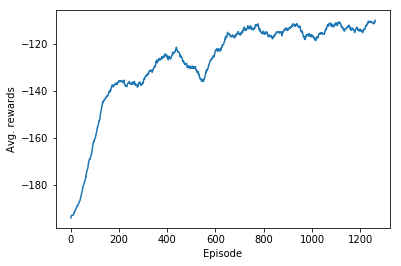

In [8]:
env = gym.make('MountainCar-v0')
semi_gradient_sarsa_control_agent = semi_gradient_sarsa_control(env, epsilon_max=0, epsilon_min=0, alpha=0.2/8)
semi_gradient_sarsa_control_agent.optimize_policy()